Task: Predict whether a user will vote on another user's posting

**Considered datasets:**
* Network of Users Who Vote on Postings (undirected) - df_edge_list_undirected_users_votes_to_postings_net
* Network on Posting Behaviour of Users (undirected) - df_edge_list_undirected_users_postings_to_same_articles
* Network of Users Who Reply to Postings (directed) - df_edge_list_directed_users_postings_replies

**Additional datasets:**
* df_Postings_filtered_net - Probably would need this as well since we can filter out posting by their date
* df_Votes_filtered_net 

In [1]:
import node2vec
from node2vec import Node2Vec
import pandas as pd
import os
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
from linkpred import LinkPred
from scipy.sparse import coo_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
import numpy as np
import random
import pickle
#maybe this one is better but don't import both Node2Vec at the same time!
#from torch_geometric.nn import Node2Vec 

We decided to experiment with the following dataframes for link prediction:
- "df_edge_list_undirected_users_votes_to_postings_net"

### Link Prediction

In [82]:
# Load the graph from dataset preparation
with open("graph.pkl", "rb") as f:
    G_undirected = pickle.load(f)

# Verify the graph is loaded
print(f"Graph: {graph.number_of_nodes()} nodes, {graph.number_of_edges()} edges")


Graph: 1000 nodes, 35141 edges


In [83]:
# check if its directed
G_undirected.is_directed()


False

In [84]:
# Sample a smaller subgraph
subgraph = G_undirected.subgraph(list(G_undirected.nodes)[:1000])  # Adjust size 

# G_directed = subgraph # comment it out when using the full graph


In [85]:
#check number of nodes
subgraph.number_of_nodes()

1000

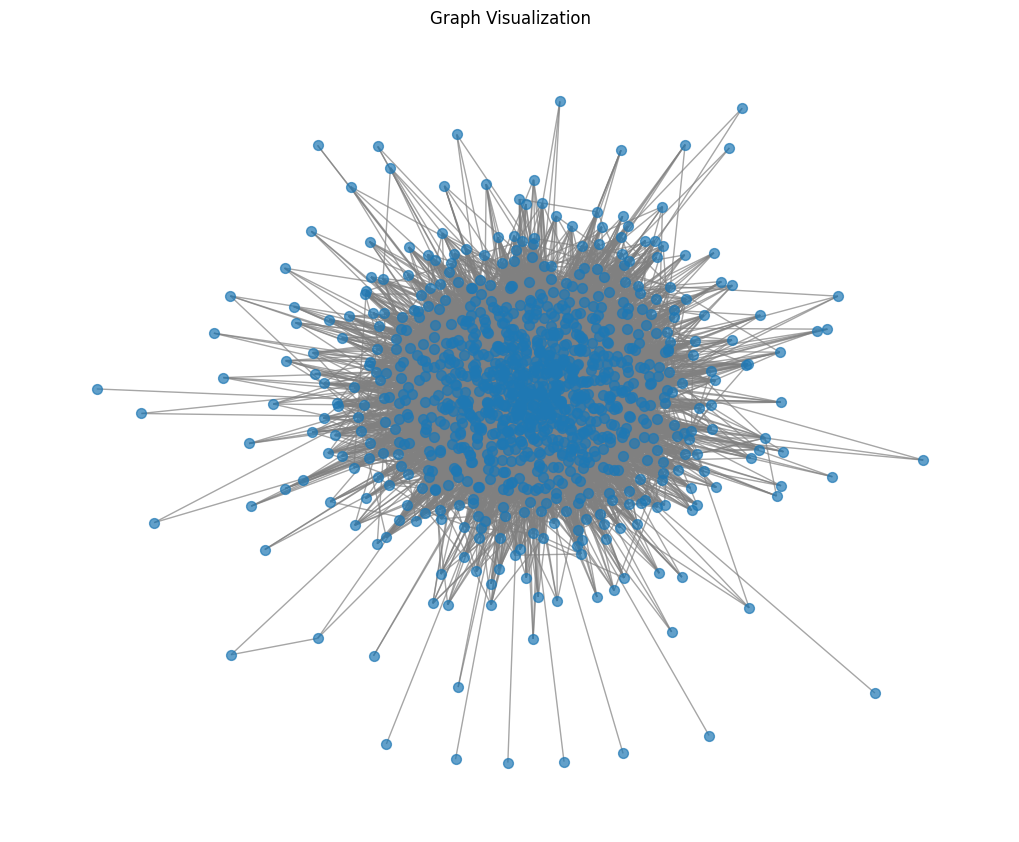

In [27]:
# Visualize the subgraph with basic layout
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subgraph) 
nx.draw(
    subgraph, 
    pos, 
    with_labels=False, 
    node_size=50, 
    edge_color='gray', 
    alpha=0.7
)
plt.title("Graph Visualization")
plt.show()

### Train Test and Validation Split

In [86]:
graph = subgraph # comment it out when using the full
# graph = G_undirected # comment it out when using the subgraph

In [87]:
len(graph.edges)

35141

In [88]:
# 1. Extract all edges (positive examples)
edges = list(graph.edges())

# 2. Split edges into train/test (85% train+val, 15% test)
train_val_edges, test_edges = train_test_split(edges, test_size=0.15, random_state=42)

# 3. Split train_val into train (70%) and validation (15%)
train_edges, val_edges = train_test_split(train_val_edges, test_size=0.1765, random_state=42)  # 0.1765 ≈ 15% of 85%

# 4. Create the train graph (only training edges)
graph_train = graph.copy()
graph_train.remove_edges_from(val_edges)
graph_train.remove_edges_from(test_edges)

# Ensure all nodes from the original graph are in the train graph
graph_train.add_nodes_from(graph.nodes())

# Print statistics
print(f"Original Graph: {graph.number_of_nodes()} nodes, {graph.number_of_edges()} edges")
print(f"Train Graph: {graph_train.number_of_nodes()} nodes, {graph_train.number_of_edges()} edges")
print(f"Training Edges: {len(train_edges)}")
print(f"Validation Edges: {len(val_edges)}")
print(f"Test Edges: {len(test_edges)}")

Original Graph: 1000 nodes, 35141 edges
Train Graph: 1000 nodes, 24597 edges
Training Edges: 24597
Validation Edges: 5272
Test Edges: 5272


In [89]:
# Generate negative edges (non-edges)
all_non_edges = set(nx.non_edges(graph))

# Sample negative edges for each set
train_neg_edges = random.sample(list(all_non_edges), len(train_edges))
val_neg_edges = random.sample(list(all_non_edges - set(train_neg_edges)), len(val_edges))
test_neg_edges = random.sample(list(all_non_edges - set(train_neg_edges) - set(val_neg_edges)), len(test_edges))

# Verify counts
print(f"Train Negative Edges: {len(train_neg_edges)}")
print(f"Validation Negative Edges: {len(val_neg_edges)}")
print(f"Test Negative Edges: {len(test_neg_edges)}")



Train Negative Edges: 24597
Validation Negative Edges: 5272
Test Negative Edges: 5272


### Train and evaluate link prediction model using node2vec

In [90]:
# Calculate node embeddings with Node2Vec on the training graph

node2vec_train = Node2Vec(
    graph=graph_train, # Use the training graph
    dimensions=64,    # Embedding dimensions
    walk_length=30,   # Length of random walks
    num_walks=200,    # Number of random walks per node
    workers=4         # Parallel threads
)

Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

python(38390) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38393) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38394) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38395) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Generating walks (CPU: 4): 100%|██████████| 50/50 [00:10<00:00,  4.89it/s]


In [91]:
# Fit the model and extract embeddings
model_train = node2vec_train.fit()
embeddings_train = {node: model_train.wv[str(node)] for node in graph_train.nodes()}

# Verify embeddings
print(f"Number of nodes in train_graph: {graph_train.number_of_nodes()}")
print(f"Number of generated embeddings: {len(embeddings_train)}")

Number of nodes in train_graph: 1000
Number of generated embeddings: 1000


In [92]:
def embedding_train(node):
    return model_train.wv[str(node)]

In [93]:
# verify embeddings
for node in list(graph_train.nodes())[:5]:
    print(f"Node {node}: {embeddings_train[node]}")

Node 163840: [-0.27632585 -0.39158484  0.15485165 -0.2799314   0.06814713 -0.08000279
  0.3825342  -0.17496334 -0.47870964  0.35846245  0.0723786  -0.34889486
 -0.05110306 -0.29456937 -0.42729223 -0.13737984 -0.4142075   0.00822648
 -0.8311414   0.12560907  0.41388428 -0.09925775 -0.14013071  0.03333776
 -0.5767733   0.31619608  0.11705664 -0.29000098  0.00788698  0.03799144
 -0.26456618 -0.10677793  0.44108728 -0.04771784  0.11812489 -0.16545692
  0.25228006  0.09463812  0.00587405  0.76603967  0.15906249  0.31093952
 -0.73293424  0.1756537   0.15096842 -0.24760811  0.15402684 -0.03773453
  0.20597152 -0.392059   -0.08111543  0.06016931  0.44272408  0.37751785
 -0.16268091 -0.3111728  -0.30962625 -0.22771181  0.06431475  0.45461613
 -0.39382645  0.03025213  0.21213776 -0.3991774 ]
Node 534531: [ 0.14119746 -0.01374284  0.29261467  0.41135925  0.26386037  0.01115092
  0.20974529 -0.60193294 -0.08501513 -0.08635403  0.05490265  0.15015678
  0.2515713  -0.24621083 -0.27257833  0.18999663

In [94]:
# Define binary operators
def operator_hadamard(u, v):
    return u * v  # Element-wise product

def operator_l1(u, v):
    return np.abs(u - v)  # L1 distance

def operator_l2(u, v):
    return (u - v) ** 2  # L2 distance

def operator_avg(u, v):
    return (u + v) / 2  # Average

# List of operators
binary_operators = {
    "Hadamard": operator_hadamard,
    "L1": operator_l1,
    "L2": operator_l2,
    "Average": operator_avg
}

In [95]:
# Generate features for positive training edges
X_train_pos = [
    operator_hadamard(embedding_train(u), embedding_train(v)) 
    for u, v in train_edges if str(u) in model_train.wv and str(v) in model_train.wv
]

# Generate features for negative training edges
X_train_neg = [
    operator_hadamard(embedding_train(u), embedding_train(v)) 
    for u, v in train_neg_edges if str(u) in model_train.wv and str(v) in model_train.wv
]

# Combine features
X_train = np.vstack([X_train_pos, X_train_neg])  # Combine positive and negative features
y_train = [1] * len(X_train_pos) + [0] * len(X_train_neg)  # Labels: 1 for positive, 0 for negative

# Verify outputs
print(f"Train Features: {len(X_train)}, Positive Edges: {len(X_train_pos)}, Negative Edges: {len(X_train_neg)}")

Train Features: 49194, Positive Edges: 24597, Negative Edges: 24597


In [96]:
# Generate features for positive validation edges
X_val_pos = [
    operator_hadamard(embedding_train(u), embedding_train(v)) 
    for u, v in val_edges if str(u) in model_train.wv and str(v) in model_train.wv
]

# Generate features for negative validation edges
X_val_neg = [
    operator_hadamard(embedding_train(u), embedding_train(v)) 
    for u, v in val_neg_edges if str(u) in model_train.wv and str(v) in model_train.wv
]

# Combine features
X_val = np.vstack([X_val_pos, X_val_neg])  # Combine positive and negative features
y_val = [1] * len(X_val_pos) + [0] * len(X_val_neg)  # Labels: 1 for positive, 0 for negative

# Verify outputs
print(f"Validation Features: {len(X_val)}, Positive Edges: {len(X_val_pos)}, Negative Edges: {len(X_val_neg)}")

Validation Features: 10544, Positive Edges: 5272, Negative Edges: 5272


In [97]:
# Train the logistic regression classifier
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [98]:
# Predict probabilities for the validation set
y_val_proba = clf.predict_proba(X_val)[:, 1]  # Probability of the positive class (1)

# Compute ROC AUC
val_auc = roc_auc_score(y_val, y_val_proba)

print(f"Validation ROC AUC: {val_auc:.4f}")

Validation ROC AUC: 0.5067


### Evaluate the best model using the test set 

In [99]:
graph_test = graph.copy()  # Replace `graph` with your main graph variable
graph_test.remove_edges_from(train_edges + val_edges)

In [100]:
# Train Node2Vec on the test graph
node2vec_test = Node2Vec(
    graph_test,  # Use the test graph
    dimensions=64,
    walk_length=30,
    num_walks=200,
    workers=4
)

Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:03<00:00, 14.45it/s]


In [101]:
model_test = node2vec_test.fit()

# Create a function to retrieve test embeddings
def embedding_test(node):
    return model_test.wv[str(node)]

In [102]:
# Generate features for test edges (positive and negative)
X_test_pos = [operator_avg(embedding_test(u), embedding_test(v)) for u, v in test_edges]
X_test_neg = [operator_avg(embedding_test(u), embedding_test(v)) for u, v in test_neg_edges]

# Combine features and labels
X_test = np.vstack([X_test_pos, X_test_neg])
y_test = [1] * len(test_edges) + [0] * len(test_neg_edges)

In [103]:
# Predict probabilities and labels for the test set
y_test_proba = clf.predict_proba(X_test)[:, 1]
y_test_pred = clf.predict(X_test)

# Calculate evaluation metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test ROC AUC: {test_roc_auc:.4f}")

Test Accuracy: 0.5151
Test ROC AUC: 0.5012


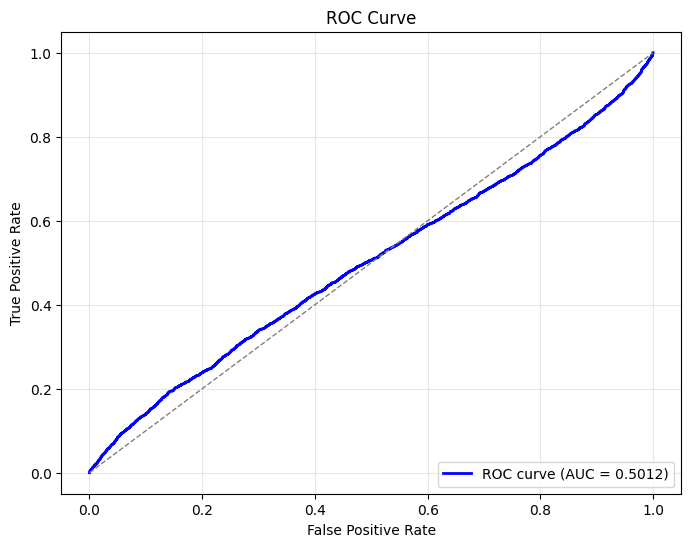

In [104]:
# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

### Tune Node2vec

#### Helper function for the generator and operator

In [105]:
# Define the operator
def operator_hadamard(embedding1, embedding2):
    """
    Computes the Hadamard operator (element-wise product) for two embeddings.
    """
    return embedding1 * embedding2

# Define the feature generator
def generate_features_with_operator(edges, embeddings, operator):
    """
    Generates features for a set of edges using the given operator and embeddings.
    """
    features = []
    for edge in edges:
        source, target = edge
        source_embedding = embeddings[source]
        target_embedding = embeddings[target]
        features.append(operator(source_embedding, target_embedding))
    return np.array(features)


In [106]:
def train_node2vec(graph, dimensions, walk_length, num_walks, p, q):
    """
    Trains a Node2Vec model and returns the learned embeddings.
    """
    node2vec = Node2Vec(
        graph=graph,
        dimensions=dimensions,
        walk_length=walk_length,
        num_walks=num_walks,
        workers=4,
        p=p,
        q=q
    )
    model = node2vec.fit()
    embeddings = {node: model.wv[str(node)] for node in graph.nodes()}
    return embeddings


In [107]:
def evaluate_on_validation_set(clf, embeddings, val_edges, val_neg_edges):
    """
    Evaluates the classifier on the validation set and computes the ROC AUC.
    """
    # Generate features
    X_val_pos = generate_features_with_operator(val_edges, embeddings, operator_hadamard)
    X_val_neg = generate_features_with_operator(val_neg_edges, embeddings, operator_hadamard)

    X_val = np.vstack([X_val_pos, X_val_neg])
    y_val = [1] * len(X_val_pos) + [0] * len(X_val_neg)
    
    # Predict probabilities
    y_val_proba = clf.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, y_val_proba)
    return val_auc


In [111]:
import csv
from itertools import product

def tune_parameters(graph_train, X_train, y_train, val_edges, val_neg_edges, dimensions=64, output_file="parameter_results.csv"):
    """
    Tunes Node2Vec parameters, saves results to a file, and print only the best parameters.
    """
    # Parameter grid
    walk_length_list = [10, 20, 30]
    num_walks_list = [10, 20, 50]
    p_list = [0.5, 1, 2]
    q_list = [0.5, 1, 2]

    best_auc = 0
    best_params = None
    results = []

    # CSV header
    with open(output_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Walk Length", "Num Walks", "p", "q", "Validation ROC AUC"])

        # Parameter tuning
        for walk_length, num_walks, p, q in product(walk_length_list, num_walks_list, p_list, q_list):
            # Train Node2Vec with current parameters
            node2vec = Node2Vec(
                graph=graph_train,
                dimensions=dimensions,
                walk_length=walk_length,
                num_walks=num_walks,
                workers=4,
                p=p,
                q=q,
                quiet=True
            )
            model = node2vec.fit()
            embeddings = {node: model.wv[str(node)] for node in graph_train.nodes()}

            # Generate validation features dynamically
            X_val_pos = [
                operator_hadamard(embeddings[u], embeddings[v])
                for u, v in val_edges if str(u) in model.wv and str(v) in model.wv
            ]
            X_val_neg = [
                operator_hadamard(embeddings[u], embeddings[v])
                for u, v in val_neg_edges if str(u) in model.wv and str(v) in model.wv
            ]
            X_val = np.vstack([X_val_pos, X_val_neg])
            y_val = [1] * len(X_val_pos) + [0] * len(X_val_neg)

            # Train logistic regression classifier
            clf = LogisticRegression(max_iter=1000, random_state=42)
            clf.fit(X_train, y_train)

            # Evaluate on validation set
            y_val_proba = clf.predict_proba(X_val)[:, 1]
            val_auc = roc_auc_score(y_val, y_val_proba)

            # Save results to file
            results.append((walk_length, num_walks, p, q, val_auc))
            writer.writerow([walk_length, num_walks, p, q, val_auc])

            # Update best parameters if necessary
            if val_auc > best_auc:
                best_auc = val_auc
                best_params = (walk_length, num_walks, p, q)

    # Print final best parameters
    print(f"Best Parameters: walk_length={best_params[0]}, num_walks={best_params[1]}, p={best_params[2]}, q={best_params[3]}")
    print(f"Best Validation ROC AUC: {best_auc:.4f}")

    return best_params, best_auc


In [112]:
# Run parameter tuning
best_params, best_auc = tune_parameters(graph_train, X_train, y_train, val_edges, val_neg_edges)


Best Parameters: walk_length=10, num_walks=10, p=1, q=2
Best Validation ROC AUC: 0.6071


### Train with Best Parameters

In [113]:
# Unpack the best parameters
best_walk_length, best_num_walks, best_p, best_q = best_params

# Train Node2Vec using the best parameters
node2vec_final = Node2Vec(
    graph=graph_train,
    dimensions=64,  # Same dimensions as during tuning
    walk_length=best_walk_length,
    num_walks=best_num_walks,
    workers=4,
    p=best_p,
    q=best_q
)
model_final = node2vec_final.fit()
embeddings_final = {node: model_final.wv[str(node)] for node in graph_train.nodes()}


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

python(39091) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(39092) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(39093) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(39094) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 19.50it/s]


In [116]:
# Verify embeddings
print(f"Number of nodes in train_graph: {graph_train.number_of_nodes()}")
print(f"Number of generated embeddings: {len(embeddings_final)}")

Number of nodes in train_graph: 1000
Number of generated embeddings: 1000


In [120]:
# Define a safe embedding fetch function
def embedding_final(node):
    return model_final.wv[str(node)] if str(node) in model_final.wv else np.zeros(64)  # Assuming 64 dimensions

# Generate features for the training set
X_train_pos_final = [
    operator_hadamard(embedding_final(u), embedding_final(v))
    for u, v in train_edges
]
X_train_neg_final = [
    operator_hadamard(embedding_final(u), embedding_final(v))
    for u, v in train_neg_edges
]
X_train_final = np.vstack([X_train_pos_final, X_train_neg_final])
y_train_final = [1] * len(X_train_pos_final) + [0] * len(X_train_neg_final)

# Verify outputs
print(f"Train Features: {len(X_train_final)}, Positive Edges: {len(X_train_pos_final)}, Negative Edges: {len(X_train_neg_final)}")


Train Features: 49194, Positive Edges: 24597, Negative Edges: 24597


In [124]:

# Train logistic regression on the final training set
clf_final = LogisticRegression(max_iter=1000, random_state=42)
clf_final.fit(X_train_final, y_train_final)


LogisticRegression(max_iter=1000, random_state=42)

In [126]:
# Generate features for positive test edges
X_test_pos = [
    operator_hadamard(embedding_final(u), embedding_final(v))
    for u, v in test_edges
]

# Generate features for negative test edges
X_test_neg = [
    operator_hadamard(embedding_final(u), embedding_final(v))
    for u, v in test_neg_edges
]

# Combine features
X_test = np.vstack([X_test_pos, X_test_neg])
y_test = [1] * len(X_test_pos) + [0] * len(X_test_neg) 

# Verify outputs
print(f"Test Features: {len(X_test)}, Positive Edges: {len(X_test_pos)}, Negative Edges: {len(X_test_neg)}")


Test Features: 10544, Positive Edges: 5272, Negative Edges: 5272


In [127]:
# Predict probabilities and labels for the test set
y_test_proba = clf.predict_proba(X_test)[:, 1]
y_test_pred = clf.predict(X_test)

# Calculate evaluation metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test ROC AUC: {test_roc_auc:.4f}")

Test Accuracy: 0.5056
Test ROC AUC: 0.5967
